In [1]:
from database import *

def ticks_to_kbars(ticks, interval='5Min'):

    kbars = pd.DataFrame()
    
    kbars['open'] = ticks['close'].resample(interval).first()
    kbars['close'] = ticks['close'].resample(interval).last()
    kbars['high'] = ticks['close'].resample(interval).max()
    kbars['low'] = ticks['close'].resample(interval).min()
    kbars['volume'] = ticks['volume'].resample(interval).sum()
    
    kbars.dropna(inplace=True)
    
    return kbars

/opt/anaconda3/lib/python3.8/site-packages/shioaji/__init__.py:20: Warning: Mac OS currently don't provide ca module all function about placing order is not working.
  warnings.warn("Mac OS currently don't provide ca module all function about placing order is not working.", Warning)


In [2]:
import talib

def get_technical_indicator(kbars):
    
    kbars['rsi'] = talib.RSI(kbars.close, timeperiod=14)
    kbars['cci'] = talib.CCI(kbars.high, kbars.low, kbars.close, timeperiod=14)
    
    macd, macdsignal, macdhist = talib.MACD(kbars.close, fastperiod=5, slowperiod=34, signalperiod=5)
    
    kbars['macd'] = macd
    kbars['macdsignal'] = macdsignal
    kbars['macdhist'] = macdhist
    
        
    kbars['slowk'], kbars['slowd'] = talib.STOCH(kbars.high,
                        kbars.low,
                        kbars.close,
                        fastk_period=9,
                        slowk_period=3,
                        slowk_matype=0,
                        slowd_period=3,
                        slowd_matype=0)

    upper, middle, lower = talib.BBANDS(kbars.close, 
                                        timeperiod=20, 
                                        nbdevup=2.1, 
                                        nbdevdn=2.1, 
                                        # Moving average type: simple moving average here
                                        matype=0)
    kbars['upper'] = upper
    kbars['middle'] = middle
    kbars['lower'] = lower
    
    return kbars

In [3]:
def day_trading_backtest(code, date, connection, api):
    
    tw_calendar = get_calendar('XTAI')
    prev_trading_date = tw_calendar.previous_close(date).date()
    
    ticks = get_ticks(code, prev_trading_date, connection, api)[0].append(get_ticks(code, date, connection, api)[0])
    kbars = ticks_to_kbars(ticks, '5Min')
    if kbars.empty:
        return pd.DataFrame()
    kbars = get_technical_indicator(kbars)
    prev_close_price = kbars['close'].get(pd.to_datetime(prev_trading_date).replace(hour=13, minute=30))
    kbars = kbars[date:]
    
    entry_price = 0
    entry_time = None
    
    exit_price = 0
    exit_time = None
    
    position = 0
    open_price = 0
            
    for ts in range(len(kbars)):
#         current_time = kbars.iloc[ts].name + pd.Timedelta(minutes=5)
        current_time = kbars.iloc[ts].name
        current_price = kbars['open'][ts]
        if ts == 0: 
            open_price = kbars['open'][ts]
            continue
        if ts ==1:
            if(kbars['close'][0] >= open_price * 1.04):
                break
#             continue
        
        if (
            position == 0 and
            current_time <= date.replace(hour=10, minute=30, second=0) and
            kbars.iloc[ts-1]['cci'] < -100 and
            kbars.iloc[ts-1]['slowk'] < 30 and
            kbars.iloc[ts-1]['rsi'] < 30
        ):
            if current_price < 20:
                position = 20
            else:
                position = 2          
            entry_price = current_price
            entry_time = current_time.time()

            print('[{}] buy {} at {}'.format(current_time, code, current_price))
        
        elif (
            position != 0 and
            ((current_price >= entry_price * 1.03) or
            (current_price <= entry_price * 0.98) or
            (current_price > entry_price and kbars.iloc[ts-1]['slowk'] > 70) or
            (current_price > entry_price and kbars.iloc[ts-1]['rsi'] > 70) or
            (current_price >= entry_price * 1.01 and kbars.iloc[ts-1]['cci'] < -60) or
            (current_price > entry_price and kbars.iloc[ts-1]['cci'] > 200) or
            (current_price > entry_price and kbars.iloc[ts-1]['upper'] < current_price))
        ):
            exit_price = current_price
            exit_time = current_time.time()
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
        elif (
            current_time >= date.replace(hour=13, minute=20, second=0) and
            position != 0
        ):
            
            exit_price = current_price
            exit_time = current_time.time()
            
            print('[{}] sell {} at {}'.format(current_time, code, current_price))
            
            break
            
    if entry_time and exit_time:
        transaction = pd.DataFrame([[date, 
                                     code, 
                                     entry_time,
                                     entry_price, 
                                     position * 1000,
                                     entry_price * position * 1000,
                                     exit_time,
                                     exit_price,
                                     position * 1000,
                                     exit_price * position * 1000]
                                   ],
                                    columns=[
                                        '成交日期', 
                                        '股票代號',
                                        '買進時間',
                                        '買進價格',
                                        '買進股數',
                                        '買進金額',
                                        '賣出時間',
                                        '賣出價格',
                                        '賣出股數',
                                        '賣出金額'])
        return transaction
    else:
        return pd.DataFrame()

In [4]:
import json

with open('config.json') as f:
  config = json.load(f)

api = sj.Shioaji()
api.login(
    person_id = config['account'],
    passwd= config['password'],
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done."))

# api.logout()

connection = sqlite3.connect('data.db')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
<SecurityType.Index: 'IND'> fetch done.


In [5]:
def get_trading_codes(codes, connection, api):
    trading_codes = []
    for code in codes:
        stock = get_stock(code, connection, api)
        if not stock[0].empty and stock[0].iloc[0]['day_trade'] == 'Yes':
            trading_codes.append(code)
    return trading_codes

In [6]:
def backtest(start_date, end_date, connection, api, discount=0.38):
    
    tw_calendar = get_calendar('XTAI')
    
    transactions = pd.DataFrame()
    update_daily_prices(start_date, end_date, connection)
    for date in pd.date_range(start_date, end_date):

        if date not in tw_calendar.opens:
            continue
        
        codes = get_stocks(date, connection)

#         day_trading_codes = [code for code in codes if get_stock(code, connection, api)[0].iloc[0]['day_trade'] == 'Yes']
        day_trading_codes = get_trading_codes(codes, connection, api)
        for code in day_trading_codes:
            
            transaction = day_trading_backtest(code, pd.to_datetime(date), connection, api)
            
            if not transaction.empty:
                transactions = transactions.append(transaction)
                
    if not transactions.empty:

        transactions['買進手續費'] = transactions['買進金額'] * 0.001425 * discount
        transactions['買進手續費'] = transactions['買進手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['買進手續費'] = transactions['買進手續費'].astype(int)

        transactions['賣出手續費'] = transactions['賣出金額'] * 0.001425 * discount
        transactions['賣出手續費'] = transactions['賣出手續費'].apply(lambda fee : fee if fee > 20 else 20)
        transactions['賣出手續費'] = transactions['賣出手續費'].astype(int)

        transactions['交易稅'] = transactions['賣出金額'] * 0.0015
        transactions['交易稅'] = transactions['交易稅'].astype(int)

        transactions['損益'] = (transactions['賣出金額'] - transactions['買進金額']) - (transactions['買進手續費'] + transactions['賣出手續費'] + transactions['交易稅'])

        transactions = transactions.set_index(['成交日期'])
        
    return transactions

In [ ]:
transactions = backtest('2021/1/1', '2021/4/28', connection, api)
transactions 

20210209 找不到資料
20210402 找不到資料
[2021-01-04 09:10:00] buy 1718 at 10.85
[2021-01-04 10:15:00] sell 1718 at 10.9
[2021-01-06 09:35:00] buy 1447 at 9.72
[2021-01-06 10:45:00] sell 1447 at 9.45
[2021-01-06 09:40:00] buy 1718 at 10.45
[2021-01-06 09:45:00] sell 1718 at 10.6
[2021-01-08 10:00:00] buy 9958 at 109.0
[2021-01-08 10:50:00] sell 9958 at 110.0
[2021-01-11 09:10:00] buy 9958 at 107.0
[2021-01-11 13:20:00] sell 9958 at 106.0
[2021-01-12 09:05:00] buy 1597 at 99.3
[2021-01-12 10:40:00] sell 1597 at 99.4
[2021-01-12 09:20:00] buy 2456 at 110.0
[2021-01-12 13:20:00] sell 2456 at 108.5
[2021-01-15 09:10:00] buy 4119 at 100.0
[2021-01-15 09:15:00] sell 4119 at 103.0
[2021-01-15 09:50:00] buy 6226 at 10.55
[2021-01-15 10:15:00] sell 6226 at 10.7
[2021-01-18 09:20:00] buy 3037 at 96.0
[2021-01-18 11:35:00] sell 3037 at 96.2
[2021-01-18 09:20:00] buy 4119 at 95.1
[2021-01-18 10:05:00] sell 4119 at 97.1
[2021-01-20 09:20:00] buy 3545 at 104.5
[2021-01-20 09:30:00] sell 3545 at 98.6
[2021-01-2

In [8]:
daily_profit_loss = transactions.resample('D').sum()
daily_profit_loss['交易次數'] = transactions.groupby('成交日期').size()
daily_profit_loss = daily_profit_loss[['買進金額', '買進手續費', '賣出金額', '賣出手續費', '交易稅', '損益', '交易次數']]
daily_profit_loss.dropna(inplace=True) 

daily_profit_loss

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-04-28,205000.0,111,209000.0,113,313,3463.0,1


In [9]:
monthly_profit_loss = daily_profit_loss.resample('M').sum()
monthly_profit_loss 

,買進金額,買進手續費,賣出金額,賣出手續費,交易稅,損益,交易次數
成交日期,,,,,,,
2021-04-30,205000.0,111,209000.0,113,313,3463.0,1


In [10]:
# 總損益
profit_loss = daily_profit_loss['損益'].sum()
profit_loss

3463.0

In [11]:
# 勝率
win_rate = round(len(transactions[transactions['損益'] > 0]) / len(transactions), 3)
win_rate

1.0

In [12]:
# 最大連續虧損
con_loss = 0
max_loss = 0

for profit_loss in daily_profit_loss["損益"]:
    
    if profit_loss < 0:
        con_loss += profit_loss
    else:
        con_loss = 0
        continue
    
    if con_loss < max_loss:
        max_loss = con_loss
        
print('最大連續虧損', max_loss)

最大連續虧損 0


/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 18745.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


[Text(0.5, 0, 'profit loss')]

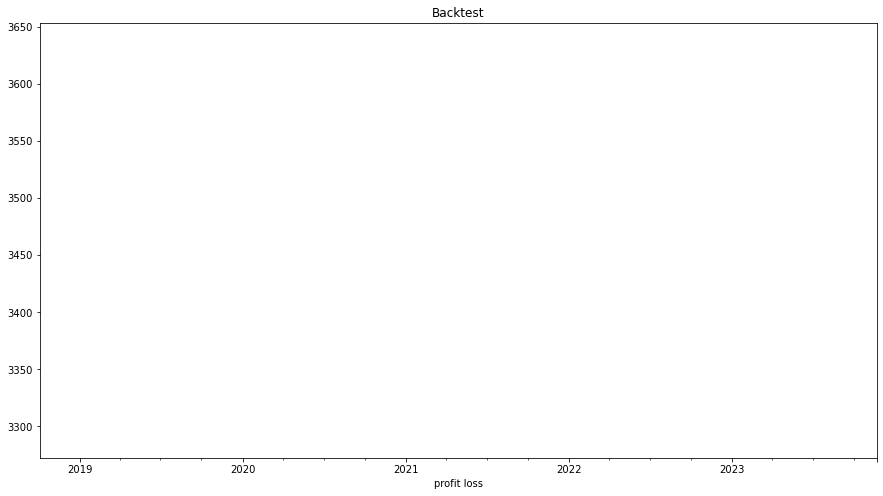

In [13]:
daily_profit_loss['損益'].cumsum()
daily_profit_loss['損益'].cumsum().plot(title='Backtest', figsize=(15, 8)).set(xlabel='profit loss')